### Building Bionomial GLM To predict Emails Open Rates (OR%) , Based on the following Features 
- Time ( month of the year , day of the week )
- Pirority of email , main or reminder 
- Category ( interval , final )
- Number of emails sent in each subject
- Constructed Features
 - Length of the subject 
 - Personalization of Email
 - Having emoji or not
 - Casual tone or formal 
 - Urgency at the subject 
 - Metion of price or discount in the subject 
 - Imperative tone in the subject 
 - Mention of product in the subject

In [1]:
#importing libraries 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


In [2]:
#r reading the data as a dataframe
df = pd.read_csv("Model_Data.csv")

In [3]:
df.columns = df.columns.str.strip()

In [4]:
columns_to_drop = [ "translation", "CTR clean %","Month"]  
df = df.drop(columns=columns_to_drop, errors='ignore')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sent_Date          1279 non-null   object 
 1   Day_of_week        1279 non-null   object 
 2   Category_name      1279 non-null   object 
 3   Main_Vs_REM        1279 non-null   object 
 4   Subject            1279 non-null   object 
 5   Sendings           1279 non-null   int64  
 6   OR                 1279 non-null   float64
 7   Length_Of_subject  1279 non-null   int64  
 8   Personalization    1279 non-null   int64  
 9   Emoji              1279 non-null   int64  
 10  Urgency            1279 non-null   int64  
 11  Tone               1279 non-null   int64  
 12  Price_or_Discount  1279 non-null   int64  
 13  Imperative_Tone    1279 non-null   int64  
 14  Product            1279 non-null   int64  
 15  Letter_Count       1279 non-null   int64  
dtypes: float64(1), int64(10)

In [6]:
# Convert to datetime
df['Sent_Date'] = pd.to_datetime(df['Sent_Date'], errors='coerce')

# Create a Month column (numeric)
df['Month'] = df['Sent_Date'].dt.month


In [7]:
# List the columns where you want to replace 1/0
cols_to_replace = ['Personalization',"Emoji",'Urgency',"Tone",'Price_or_Discount','Imperative_Tone','Product']
  

# Replace 1 → 'yes' and 0 → 'no' in those columns
df[cols_to_replace] = df[cols_to_replace].replace({1: 'yes', 0: 'no'})
df["Length_Of_subject"]=df["Length_Of_subject"].replace({1: "long", 0:"short"})
month_map = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}

# Replace numeric month values with names
df["Month"] = df["Month"].map(month_map)





In [8]:
df.columns

Index(['Sent_Date', 'Day_of_week', 'Category_name', 'Main_Vs_REM', 'Subject',
       'Sendings', 'OR', 'Length_Of_subject', 'Personalization', 'Emoji',
       'Urgency', 'Tone', 'Price_or_Discount', 'Imperative_Tone', 'Product',
       'Letter_Count', 'Month'],
      dtype='object')

In [9]:
categorical_columns = [
    'Day_of_week',
    'Category_name',
    'Main_Vs_REM',
    'Personalization',
    'Emoji',
    'Urgency',
    'Tone',
    'Price_or_Discount',
    'Imperative_Tone',
    'Product',
    'Length_Of_subject',
    'Month',
    "Subject"
]

for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].astype('category')
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")


In [10]:
# List the columns where you want to replace 1/0
cols_to_replace = ['Personalization',"Emoji",'Urgency',"Tone",'Price_or_Discount','Imperative_Tone','Product']
  

# Replace 1 → 'yes' and 0 → 'no' in those columns
df[cols_to_replace] = df[cols_to_replace].replace({1: 'yes', 0: 'no'})
df["Length_Of_subject"]=df["Length_Of_subject"].replace({1: "long", 0:"short"})


# Quick check
print(df[cols_to_replace].head())
print(df["Length_Of_subject"].head())



  Personalization Emoji Urgency Tone Price_or_Discount Imperative_Tone Product
0              no    no      no   no               yes              no     yes
1              no    no      no   no                no              no     yes
2              no   yes      no  yes                no              no      no
3              no   yes     yes  yes               yes              no      no
4              no    no      no   no               yes              no     yes
0    short
1    short
2    short
3     long
4    short
Name: Length_Of_subject, dtype: category
Categories (2, object): ['long', 'short']


Next , I will confirm that the values in "OR clean %" is a valid percentage 

In [11]:
# Check if all values are between 0 and 1
valid_percentage = df['OR'].between(0, 1).all()

if valid_percentage:
    print("All values in 'OR' are valid percentages (0 to 1).")
else:
    # Show which rows are invalid
    invalid_rows = df[~df['OR'].between(0, 1)]
    print("Some values are outside 0 to 1:")
    display(invalid_rows)


All values in 'OR' are valid percentages (0 to 1).


In [12]:
import pandas as pd
import numpy as np
from scipy import stats

def get_column_outliers(df, columns=['Sendings', 'OR'], threshold=3):
    """
    Detect outliers in each specified numeric column using Z-score.
    
    Parameters:
    - df: pandas DataFrame
    - columns: list of column names to check
    - threshold: Z-score cutoff (default 3)
    
    Returns:
    - Dictionary: column name -> DataFrame of outlier rows
    """
    outlier_dict = {}
    
    for col in columns:
        if col in df.columns:
            col_data = df[col]
            z_scores = np.abs(stats.zscore(col_data.dropna()))
            col_outliers = df.loc[col_data.dropna().index[z_scores > threshold]]
            outlier_dict[col] = col_outliers
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
            outlier_dict[col] = pd.DataFrame()  # empty DataFrame if column not found
    
    return outlier_dict

# Example usage
outliers = get_column_outliers(df, columns=['Sendings', 'OR'], threshold=3)

print("Outliers in 'Sendings':")
display(outliers['Sendings'])

print("Outliers in 'OR%':")
display(outliers['OR'])


Outliers in 'Sendings':


,Sent_Date,Day_of_week,Category_name,Main_Vs_REM,Subject,Sendings,OR,Length_Of_subject,Personalization,Emoji,Urgency,Tone,Price_or_Discount,Imperative_Tone,Product,Letter_Count,Month
787,2024-12-10,Sunday,NL Interval,MAIN,(72h) Upp till 65% rabatt på Väggdekorationer!,241155,0.0706,short,no,no,yes,no,yes,no,yes,30,December
846,2024-11-19,Sunday,NL Interval,MAIN,(72h) Upp till 65% rabatt på Väggdekorationer!,239688,0.0724,short,no,no,yes,no,yes,no,yes,30,November
869,2024-11-15,Wednesday,NL Interval,MAIN,Missa inte - Fotopresenter från endast 59 kr!,239832,0.0811,short,no,no,no,yes,yes,yes,yes,33,November
870,2024-11-24,Friday,NL Interval,MAIN,Upp till -63% på favorit Väggdekorationer!,241218,0.0694,short,no,no,no,no,yes,no,yes,30,November
885,2024-11-29,Wednesday,NL Interval,MAIN,Skynda dig! Väggdekor från endast 39kr!,241500,0.0815,short,no,no,yes,yes,yes,yes,yes,28,November
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2024-11-10,Friday,NL Interval,MAIN,Upp till 58% rabatt på de mest älskade Canvast...,239778,0.0758,short,no,yes,no,yes,yes,no,yes,38,November
1258,2024-10-20,Friday,NL Interval,MAIN,Upp till 58% rabatt på de mest älskade Canvast...,239931,0.0760,short,no,yes,no,yes,yes,no,yes,38,October
1261,2024-11-01,Wednesday,NL Interval,MAIN,✨ 3 Canvastavlor | 2 dagar | Upp till 54% rabatt!,239781,0.0790,short,no,yes,yes,yes,yes,no,yes,30,November
1268,2024-08-25,Friday,NL Interval,MAIN,2 dagar | Canvastavlor från endast 185 kr!,237564,0.0637,short,no,no,yes,no,yes,no,yes,28,August


Outliers in 'OR%':


,Sent_Date,Day_of_week,Category_name,Main_Vs_REM,Subject,Sendings,OR,Length_Of_subject,Personalization,Emoji,Urgency,Tone,Price_or_Discount,Imperative_Tone,Product,Letter_Count,Month
1,2024-08-02,Wednesday,NL Interval,MAIN,Dekorativ inredning för hemmet till de bästa p...,246,0.2927,short,no,no,no,no,no,no,yes,42,August
10,2024-11-01,Wednesday,NL Interval,MAIN,Otroligt ✨ 3 XXL-format för 249 kr styck,339,0.2566,short,no,yes,no,yes,yes,no,no,26,November
22,2024-07-02,Sunday,NL Interval,MAIN,Premiumtryck upp till 78% rabatt!,315,0.2571,short,no,no,no,no,yes,no,yes,25,July
36,2024-12-03,Sunday,NL Interval,MAIN,Dekorativ inredning för hemmet till de bästa p...,345,0.2609,short,no,no,no,no,no,no,yes,42,December
37,2024-07-02,Sunday,NL Interval,MAIN,Personlig väggdekoration till fantastiska priser!,279,0.2581,short,no,no,no,no,no,no,yes,43,July
68,2024-03-01,Wednesday,NL Interval,MAIN,Dekorativ inredning för hemmet till de bästa p...,228,0.2763,short,no,no,no,no,no,no,yes,42,March
108,2024-03-01,Wednesday,NL Interval,MAIN,Personlig väggdekoration till fantastiska priser!,300,0.3200,short,no,no,no,no,no,no,yes,43,March
124,2024-03-22,Wednesday,NL Interval,MAIN,✨ 3 Canvastavlor | 2 dagar | Upp till 54% rabatt!,1188,0.3157,short,no,yes,yes,yes,yes,no,yes,30,March
317,2024-10-01,Sunday,NL Interval,MAIN,Otroligt ✨ 3 XXL-format för 249 kr styck,345,0.2957,short,no,yes,no,yes,yes,no,no,26,October
638,2024-03-29,Wednesday,NL Interval,MAIN,✨ 3 Canvastavlor | 2 dagar | Upp till 54% rabatt!,1383,0.2625,short,no,yes,yes,yes,yes,no,yes,30,March


In [13]:

# Set Winsorization thresholds (percentiles)
lower_pct = 0.01  # 1st percentile
upper_pct = 0.99  # 99th percentile

# List of columns to Winsorize
columns_to_winsorize = ['Sendings', 'OR']

for col in columns_to_winsorize:
    lower = df[col].quantile(lower_pct)
    upper = df[col].quantile(upper_pct)
    df[col] = np.clip(df[col], lower, upper)  # Cap values at thresholds
    print(f"{col}: capped below {lower:.3f}, capped above {upper:.3f}")

# Now df has Winsorized columns ready for modeling


Sendings: capped below 357.000, capped above 241306.620
OR: capped below 0.057, capped above 0.229


- Confirming that Data is valid for regression models 
 - Cheking correlation 
 - Ckeking multicoliniarity

In [14]:
# code to check correlation 
target = "OR"  

numeric_df = df.select_dtypes(include=['int64', 'float64'])
corr_with_target = numeric_df.corr()[target].sort_values(ascending=False)

print("\n✅ Correlation with target:")
print(corr_with_target)


✅ Correlation with target:
OR              1.000000
Letter_Count    0.004514
Sendings       -0.395565
Name: OR, dtype: float64


In [15]:
# code to check multicolinearity 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = numeric_df.drop(columns=[target])  
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\n✅ VIF to detect multicollinearity:")
print(vif_data)


✅ VIF to detect multicollinearity:
        feature       VIF
0      Sendings  1.450841
1  Letter_Count  1.450841


In [16]:
df.to_csv("my_data.csv", index=False)

The previous result shows that there is no multicolinearity effect 


### Building bionomial GLM  model 

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


In [18]:
df['opens'] = (df['OR'] * df['Sendings']).round().astype(int)
df['non_opens'] = df['Sendings'] - df['opens']

In [19]:
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
df = df.sort_values('Sent_Date')

# Define cutoff date (e.g., last 20% of records for testing)
cutoff_index = int(len(df) * 0.8)
train_df = df.iloc[:cutoff_index]
test_df = df.iloc[cutoff_index:]

print(f"Training data: {train_df['Sent_Date'].min().date()} → {train_df['Sent_Date'].max().date()}")
print(f"Testing data:  {test_df['Sent_Date'].min().date()} → {test_df['Sent_Date'].max().date()}")
print(f"\n📊 Train size: {len(train_df)}, Test size: {len(test_df)}")


Training data: 2024-01-01 → 2024-11-02
Testing data:  2024-11-02 → 2024-12-31

📊 Train size: 1023, Test size: 256


In [20]:
categorical_cols = [
      'Day_of_week',
    'Category_name',
    'Main_Vs_REM',
    'Personalization',
    'Emoji',
    'Urgency',
    'Tone',
    'Price_or_Discount',
    'Imperative_Tone',
    'Product',
    'Length_Of_subject',
    'Month',
    "Subject"
]

# Automatically detect numeric features (excluding target + weight)
numeric_cols = [
    col for col in train_df.select_dtypes(include=[np.number]).columns
    if col not in ['OR', 'Sendings', 'opens', 'non_opens']]


In [21]:
X_train_cat = pd.get_dummies(train_df[categorical_cols], drop_first=True, dtype=int)
X_test_cat  = pd.get_dummies(test_df[categorical_cols],  drop_first=True, dtype=int)

In [22]:
X_train_num = train_df[numeric_cols].reset_index(drop=True)
X_test_num  = test_df[numeric_cols].reset_index(drop=True)

In [23]:
X_train = pd.concat([X_train_num.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test  = pd.concat([X_test_num.reset_index(drop=True),  X_test_cat.reset_index(drop=True)], axis=1)

In [24]:
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [25]:
# Ensure all columns numeric (no bool/object left)
X_train = X_train.astype(float)
X_test  = X_test.astype(float)

Here, Sendings are built into y, so you’re automatically weighting each row by its number of trials.

In [26]:
# --- 4. prepare response (two-column) and indices alignment
y_train = train_df[['opens', 'non_opens']].reset_index(drop=True)
y_test  = test_df[['opens', 'non_opens']].reset_index(drop=True)

In [27]:
# Reset indices for everything to avoid index-mismatch errors
X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)

In [28]:
# --- 5. add intercept and fit Binomial GLM (uses counts as endog) ---
X_train_const = sm.add_constant(X_train, has_constant='add').astype(float)
X_test_const  = sm.add_constant(X_test,  has_constant='add').astype(float)

In [29]:
glm_binom = sm.GLM(
    y_train,                      # endog: two columns [successes, failures]
    X_train_const,
    family=sm.families.Binomial()
)
result = glm_binom.fit()
print(result.summary())

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['opens', 'non_opens']   No. Observations:                 1023
Model:                                GLM   Df Residuals:                      989
Model Family:                    Binomial   Df Model:                           33
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -68279.
Date:                    Tue, 21 Oct 2025   Deviance:                   1.2686e+05
Time:                            12:06:45   Pearson chi2:                 1.35e+05
No. Iterations:                         6   Pseudo R-squ. (CS):              1.000
Covariance Type:                nonrobust                                         
                                                                                                                                                                          

In [30]:
# --- 6. predict probabilities on test set ---
# result.predict returns predicted probability of success (open rate)
test_df = test_df.reset_index(drop=True)  # keep row alignment
test_df['pred_open_rate'] = result.predict(X_test_const)

In [31]:
# predicted opens (optional)
test_df['pred_opens'] = (test_df['pred_open_rate'] * test_df['Sendings']).round().astype(int)

In [32]:
# --- 8. evaluation (use proportions for comparability) ---
# drop any rows with missing actual/predicted (should be none)
eval_df = test_df.dropna(subset=['OR', 'pred_open_rate']).copy()
y_true = eval_df['OR']
y_pred = eval_df['pred_open_rate']

In [33]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
corr, _ = pearsonr(y_true, y_pred)

# McFadden pseudo-R² (note: can be negative if model worse than null)
llf = result.llf
llnull = result.null_deviance / -2.0
pseudo_r2 = 1 - (llf / llnull)

print("\nMODEL PERFORMANCE (Test set)")
print(f"Rows evaluated: {len(eval_df)}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"Pearson r: {corr:.4f}")
print(f"McFadden pseudo-R²: {pseudo_r2:.4f}")


MODEL PERFORMANCE (Test set)
Rows evaluated: 256
MAE: 0.0264
RMSE: 0.0355
R²: -0.3211
Pearson r: 0.4636
McFadden pseudo-R²: 0.8153


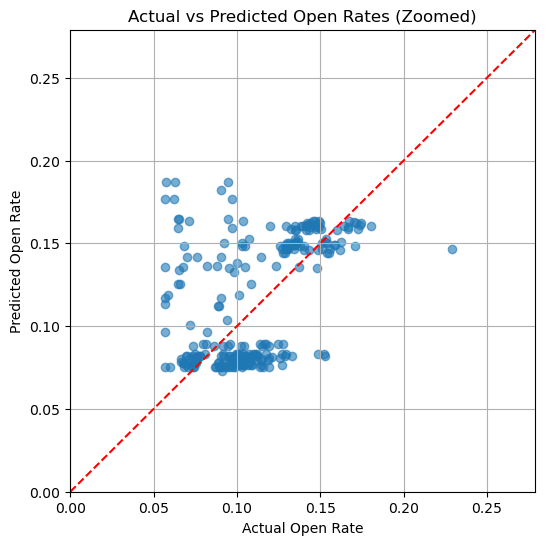

In [34]:
# --- 9. plots (zoomed because your data < 0.5 mostly) ---
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6)
max_val = max(y_true.max(), y_pred.max())
upper_limit = min(0.6, float(round(max_val + 0.05, 3)))
plt.plot([0, upper_limit], [0, upper_limit], 'r--')
plt.xlim(0, upper_limit)
plt.ylim(0, upper_limit)
plt.xlabel('Actual Open Rate')
plt.ylabel('Predicted Open Rate')
plt.title('Actual vs Predicted Open Rates (Zoomed)')
plt.grid(True)
plt.show()

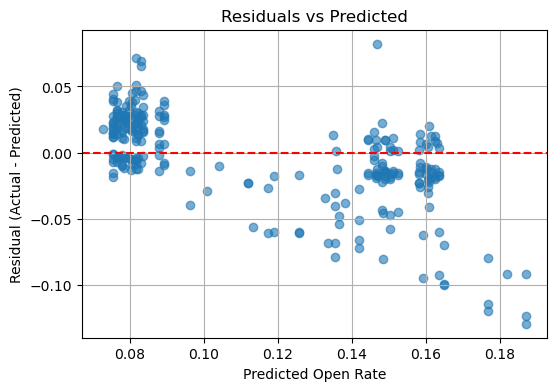

In [35]:
# Residuals
residuals = y_true - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Open Rate')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals vs Predicted')
plt.grid(True)
plt.show()

In [36]:
import pandas as pd
import numpy as np

# Extract coefficients and related stats
coef_df = pd.DataFrame({
    'Feature': result.params.index,
    'Coefficient': result.params.values,
    'Std_Err': result.bse.values,
    'p_value': result.pvalues.values
})

# Add Odds Ratios (exp(coefficient))
coef_df['Odds_Ratio'] = np.exp(coef_df['Coefficient'])

# Sort by absolute impact
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

# Keep top 20 (excluding intercept)
top20 = coef_df[coef_df['Feature'] != 'const'].head(20)

# Display nicely formatted
pd.set_option('display.float_format', '{:.4f}'.format)
print("\n📊 Top 20 Most Important Features (by absolute coefficient size):\n")
print(top20)




📊 Top 20 Most Important Features (by absolute coefficient size):

                                              Feature  Coefficient  Std_Err  \
61  Subject_Upp till -63% på favorit Väggdekoratio...      -0.5397   0.0030   
17                            Length_Of_subject_short      -0.4376   0.0018   
14                              Price_or_Discount_yes      -0.3521   0.0015   
12                                        Urgency_yes      -0.3453   0.0018   
47  Subject_Dekorativ inredning för hemmet till de...       0.3149   0.0038   
62  Subject_Upp till 58% rabatt på de mest älskade...      -0.2890   0.0040   
48  Subject_Dina bilder på Canvastavla eller Fotop...       0.2783   0.0021   
4                                  Day_of_week_Sunday      -0.2532   0.0059   
42  Subject_2 dagar | Canvastavlor från endast 185...      -0.2450   0.0038   
50      Subject_Hem och livsstil-produkter från 49 kr      -0.2359   0.0023   
5                                Day_of_week_Thursday      -0.22

C:\Users\TOWER-PC\AppData\Local\Temp\ipykernel_12196\3956631135.py:9: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
  plt.tight_layout()
c:\Users\TOWER-PC\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


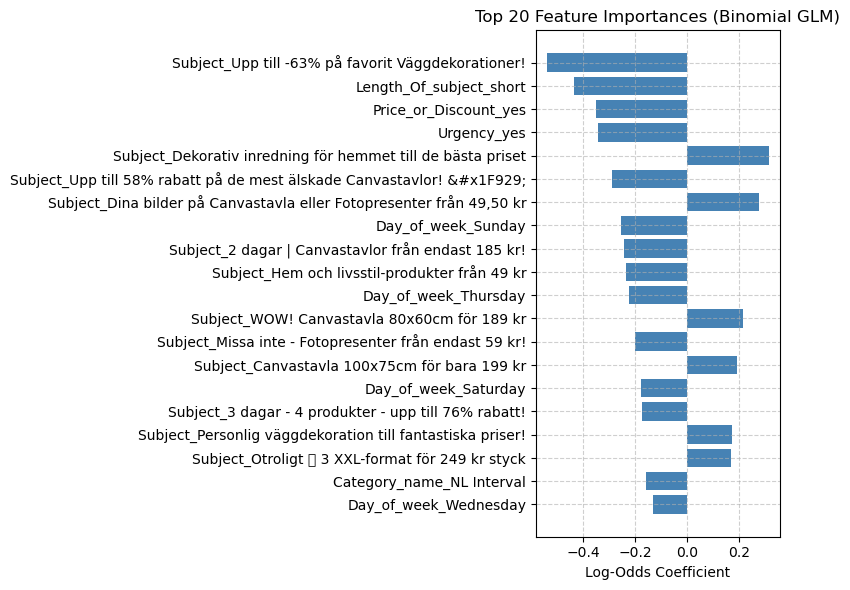

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.barh(top20['Feature'], top20['Coefficient'], color='steelblue')
plt.xlabel('Log-Odds Coefficient')
plt.title('Top 20 Feature Importances (Binomial GLM)')
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [38]:
import pandas as pd
from IPython.display import display, HTML

# Extract subject-related coefficients
subject_effects = coef_df[coef_df["Feature"].str.startswith("Subject_")].copy()

# Clean up names
subject_effects["Subject"] = subject_effects["Feature"].str.replace("Subject_", "", regex=False)

# Sort by effect size (descending)
subject_effects = subject_effects.sort_values("Coefficient", ascending=False)

# Keep only relevant columns
subject_effects = subject_effects[["Subject", "Coefficient", "Odds_Ratio"]]

# Round for readability
subject_effects["Coefficient"] = subject_effects["Coefficient"].round(4)
subject_effects["Odds_Ratio"] = subject_effects["Odds_Ratio"].round(3)

# Select top 10
top_subjects = subject_effects.head(10).reset_index(drop=True)

# Display as styled table
print("📬 <b>Top 10 Subjects That Increase Open Rate</b>")
display(HTML(top_subjects.to_html(index=False, justify="center")))



📬 <b>Top 10 Subjects That Increase Open Rate</b>


Subject,Coefficient,Odds_Ratio
Dekorativ inredning för hemmet till de bästa priset,0.3149,1.3700
"Dina bilder på Canvastavla eller Fotopresenter från 49,50 kr",0.2783,1.3210
WOW! Canvastavla 80x60cm för 189 kr,0.2154,1.2400
Canvastavla 100x75cm för bara 199 kr,0.1920,1.2120
Personlig väggdekoration till fantastiska priser!,0.1728,1.1890
Otroligt ✨ 3 XXL-format för 249 kr styck,0.1679,1.1830
Premiumtryck upp till 78% rabatt!,0.1102,1.1170
Skynda dig! Väggdekor från endast 39kr!,0.1018,1.1070
✨ 3 Canvastavlor | 2 dagar | Upp till 54% rabatt!,0.0457,1.0470
"&#x1f4af; Ju större duk, desto större rabatt! Black Friday erbjudande!",0.0000,1.0000


C:\Users\TOWER-PC\AppData\Local\Temp\ipykernel_12196\1161176239.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration = df_cal.groupby('bin').agg(


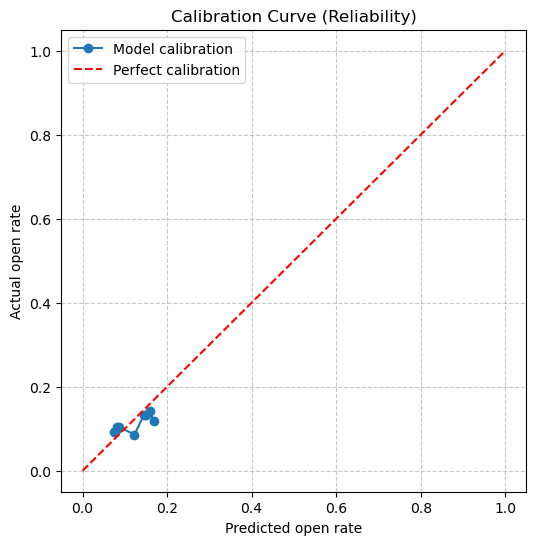


📏 Mean Absolute Error (MAE): 0.0264

🚀 Top-decile lift: 1.06x
   (Top 10% avg open rate = 0.117, overall avg = 0.110)

📊 Top 20 Drivers (with 95% Confidence Intervals):

                                              Feature  Coefficient  Lower_CI  \
61  Subject_Upp till -63% på favorit Väggdekoratio...      -0.5397   -0.5456   
17                            Length_Of_subject_short      -0.4376   -0.4411   
14                              Price_or_Discount_yes      -0.3521   -0.3551   
12                                        Urgency_yes      -0.3453   -0.3488   
47  Subject_Dekorativ inredning för hemmet till de...       0.3149    0.3075   
62  Subject_Upp till 58% rabatt på de mest älskade...      -0.2890   -0.2968   
48  Subject_Dina bilder på Canvastavla eller Fotop...       0.2783    0.2742   
4                                  Day_of_week_Sunday      -0.2532   -0.2647   
42  Subject_2 dagar | Canvastavlor från endast 185...      -0.2450   -0.2524   
50      Subject_Hem och livss

C:\Users\TOWER-PC\AppData\Local\Temp\ipykernel_12196\1161176239.py:83: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
  plt.tight_layout()
c:\Users\TOWER-PC\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


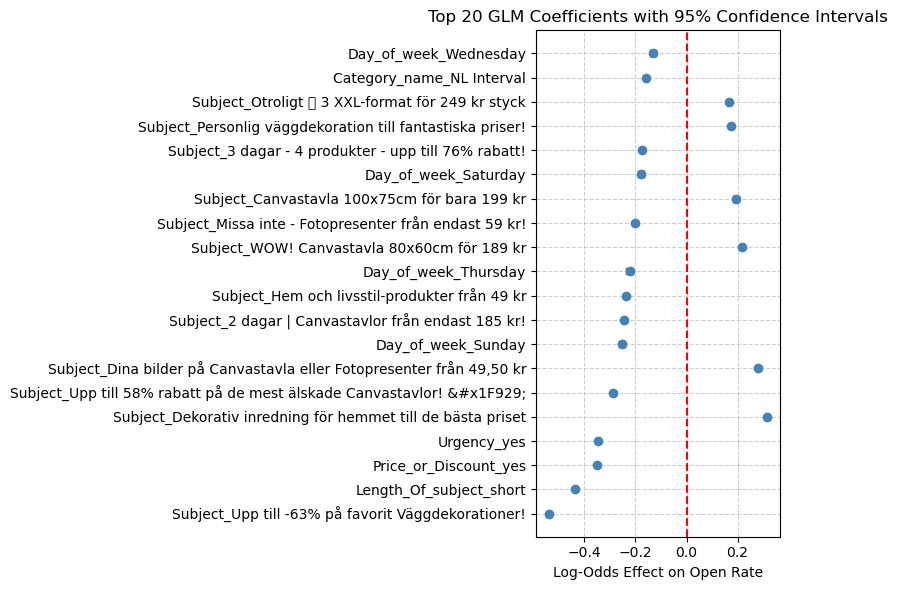

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# ========== 1️⃣ CALIBRATION CURVE (reliability plot) ==========

y_true = test_df['OR']        # actual open rate
y_pred = test_df['pred_open_rate']  # predicted open rate (probability)

# Remove NaNs for safe plotting
mask = (~y_true.isna()) & (~y_pred.isna())
y_true = y_true[mask]
y_pred = y_pred[mask]

# ✅ FIX: manual calibration for continuous proportions
df_cal = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
df_cal['bin'] = pd.qcut(df_cal['y_pred'], q=10, duplicates='drop')

calibration = df_cal.groupby('bin').agg(
    prob_pred=('y_pred', 'mean'),
    prob_true=('y_true', 'mean'),
    count=('y_true', 'size')
).reset_index()

plt.figure(figsize=(6, 6))
plt.plot(calibration['prob_pred'], calibration['prob_true'], 'o-', label='Model calibration')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect calibration')
plt.xlabel('Predicted open rate')
plt.ylabel('Actual open rate')
plt.title('Calibration Curve (Reliability)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# ========== 2️⃣ MAE ==========
mae = mean_absolute_error(y_true, y_pred)
print(f"\n📏 Mean Absolute Error (MAE): {mae:.4f}")

# ========== 3️⃣ TOP-DECILE LIFT ==========
df_eval = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
df_eval = df_eval.sort_values('y_pred', ascending=False)
cutoff = int(0.1 * len(df_eval))

overall_mean = df_eval['y_true'].mean()
top_decile_mean = df_eval.head(cutoff)['y_true'].mean()
lift = top_decile_mean / overall_mean

print(f"\n🚀 Top-decile lift: {lift:.2f}x")
print(f"   (Top 10% avg open rate = {top_decile_mean:.3f}, overall avg = {overall_mean:.3f})")

# ========== 4️⃣ DRIVERS (GLM coefficients with 95% CI) ==========
coef_summary = pd.DataFrame({
    'Feature': result.params.index,
    'Coefficient': result.params.values,
    'Std_Err': result.bse.values,
    'p_value': result.pvalues.values
})
coef_summary['Lower_CI'] = coef_summary['Coefficient'] - 1.96 * coef_summary['Std_Err']
coef_summary['Upper_CI'] = coef_summary['Coefficient'] + 1.96 * coef_summary['Std_Err']
coef_summary['Odds_Ratio'] = np.exp(coef_summary['Coefficient'])
coef_summary['Lower_OR'] = np.exp(coef_summary['Lower_CI'])
coef_summary['Upper_OR'] = np.exp(coef_summary['Upper_CI'])

coef_summary = coef_summary.reindex(coef_summary['Coefficient'].abs().sort_values(ascending=False).index)
top_coef = coef_summary[coef_summary['Feature'] != 'const'].head(20)

print("\n📊 Top 20 Drivers (with 95% Confidence Intervals):\n")
print(top_coef[['Feature', 'Coefficient', 'Lower_CI', 'Upper_CI', 'Odds_Ratio', 'p_value']])

# ========== 5️⃣ OPTIONAL: Visualize Drivers ==========
plt.figure(figsize=(8, 6))
plt.errorbar(
    x=top_coef['Coefficient'],
    y=top_coef['Feature'],
    xerr=1.96 * top_coef['Std_Err'],
    fmt='o', color='steelblue', ecolor='gray', elinewidth=2, capsize=3
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Top 20 GLM Coefficients with 95% Confidence Intervals')
plt.xlabel('Log-Odds Effect on Open Rate')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [40]:


import pandas as pd
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact

def interactive_open_rate_predictor_glm(result):
    """
    Interactive predictor for Open Rate using GLM binomial model.
    Allows user to input key features (including Sendings).
    """

    # === Define feature options ===
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday']
    categories = ['NL Interval']
    main_rem = ['REM', 'Main']
    yes_no = ['yes', 'no']
    lengths = ['short']
    months = [
        'January', 'February', 'March', 'May', 'June', 'July', 'August',
        'September', 'October', 'November', 'December'
    ]

    # === Prediction function ===
    def _predict(
        Letter_Count,
        Day_of_week,
        Category_name,
        Main_Vs_REM,
        Personalization,
        Emoji,
        Urgency,
        Tone,
        Price_or_Discount,
        Imperative_Tone,
        Product,
        Length_Of_subject,
        Month,
        Sendings
    ):
        # Create a row matching model columns
        X_input = pd.DataFrame(columns=result.params.index)
        X_input.loc[0] = 0  # initialize all 0
        X_input['const'] = 1
        X_input['Letter_Count'] = Letter_Count

        # Encode categorical selections
        X_input[f'Day_of_week_{Day_of_week}'] = 1
        X_input[f'Category_name_{Category_name}'] = 1
        X_input[f'Main_Vs_REM_{Main_Vs_REM}'] = 1
        X_input[f'Personalization_{Personalization}'] = 1
        X_input[f'Emoji_{Emoji}'] = 1
        X_input[f'Urgency_{Urgency}'] = 1
        X_input[f'Tone_{Tone}'] = 1
        X_input[f'Price_or_Discount_{Price_or_Discount}'] = 1
        X_input[f'Imperative_Tone_{Imperative_Tone}'] = 1
        X_input[f'Product_{Product}'] = 1
        X_input[f'Length_Of_subject_{Length_Of_subject}'] = 1
        X_input[f'Month_{Month}'] = 1

        # Add Sendings as numeric predictor
        X_input['Sendings'] = Sendings

        # Align columns (fill any missing)
        for col in result.params.index:
            if col not in X_input.columns:
                X_input[col] = 0
        X_input = X_input[result.params.index]

        # Predict open rate
        pred_rate = result.predict(X_input)[0]
        print(f"\n📧 Predicted Open Rate: {pred_rate:.3f} ({pred_rate*100:.1f}%)")

    # === Build the interactive UI ===
    interact(
        _predict,
        Letter_Count=widgets.IntSlider(value=40, min=10, max=100, step=1, description='Letter Count'),
        Day_of_week=widgets.Dropdown(options=days, description='Day'),
        Category_name=widgets.Dropdown(options=categories, description='Category'),
        Main_Vs_REM=widgets.Dropdown(options=main_rem, description='Main/REM'),
        Personalization=widgets.Dropdown(options=yes_no, description='Personalization'),
        Emoji=widgets.Dropdown(options=yes_no, description='Emoji'),
        Urgency=widgets.Dropdown(options=yes_no, description='Urgency'),
        Tone=widgets.Dropdown(options=yes_no, description='Tone'),
        Price_or_Discount=widgets.Dropdown(options=yes_no, description='Price/Discount'),
        Imperative_Tone=widgets.Dropdown(options=yes_no, description='Imperative'),
        Product=widgets.Dropdown(options=['yes'], description='Product'),
        Length_Of_subject=widgets.Dropdown(options=lengths, description='Length'),
        Month=widgets.Dropdown(options=months, description='Month'),
        Sendings=widgets.IntSlider(value=3000, min=100, max=10000, step=100, description='Sendings')
    )



In [41]:
interactive_open_rate_predictor_glm(result)


interactive(children=(IntSlider(value=40, description='Letter Count', min=10), Dropdown(description='Day', opt…

Summary:
Your model is moderately reliable — it clearly captures some meaningful signal (likely category, personalization, or tone effects), but not the full complexity of open-rate behavior (which depends heavily on audience, time, and context).

You can trust it for directional insights (e.g., which features increase open rate) and rough forecasting,
but not for precise prediction (e.g., campaign-level open rate within ±1%).